In [3]:
import os
os.getcwd()

'C:\\Users\\Albert\\Desktop\\DATA SCIENCE\\UBIQUM\\UBIQUM_1X2_Python\\notebooks'

In [4]:
import pandas as pd

xl = pd.ExcelFile('../bbdd/FULL_BBDD_with_features.xlsx')
df = xl.parse(xl.sheet_names[0])

In [5]:
df.columns

Index(['TEMPORADA', 'LIGA', 'JORNADA', 'FECHA', 'LOCAL', 'VISITANTE', 'GOL L',
       'GOL V', 'ARBITRO', 'QUINIELA', 'last2_hometeam_w', 'last2_hometeam_d',
       'last2_hometeam_l', 'last5_hometeam_w', 'last5_hometeam_d',
       'last5_hometeam_l', 'last10_hometeam_w', 'last10_hometeam_d',
       'last10_hometeam_l', 'last2_awayteam_w', 'last2_awayteam_d',
       'last2_awayteam_l', 'last5_awayteam_w', 'last5_awayteam_d',
       'last5_awayteam_l', 'last10_awayteam_w', 'last10_awayteam_d',
       'last10_awayteam_l', 'league_local_local_w', 'league_local_local_d',
       'league_local_local_l', 'league_visitor_visitor_w',
       'league_visitor_visitor_d', 'league_visitor_visitor_l', 'h2h_last_10_h',
       'h2h_last_10_d', 'h2h_last_10_a', 'h2h_5_homeaway_h',
       'h2h_5_homeaway_d', 'h2h_5_homeaway_a', 'ref_hometeam_w',
       'ref_hometeam_d', 'ref_hometeam_l', 'ref_awayteam_w', 'ref_awayteam_d',
       'ref_awayteam_l', 'ref_home_home_w', 'ref_home_home_d',
       'ref_home_ho

### Preparing models (create train and test, scaling, filtering information)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

Select what part of the dataframe i want to model and create the final dataframe

In [106]:
jornada_cut = 10
league_selec = 1
selec = df[(df['JORNADA']>=jornada_cut) & (df['JORNADA']<34) & (df['LIGA'] == league_selec)]

In [107]:
x_col = selec.columns[[i[-2:] in ['_l', '_w', '_d', '_h','_a' ] for i in list(selec.columns)]]
X = selec[x_col]
y = selec['QUINIELA']

Create the train and testing set after scaling it, just in case i apply a distance based ML model.

In [108]:
Xs = scale(X)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.30, random_state=100)

### Apply models (RF, GBT, kNN, SVM)

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# model
rfc = RandomForestClassifier(n_estimators=100, random_state=88)
rfc.fit(X_train, y_train)

# prediction
predsrfc = rfc.predict(X_test)

# results
print('Accuracy:', round(accuracy_score(y_test, predsrfc),4), "|", "Kappa:", round(cohen_kappa_score(y_test, predsrfc),4))

Accuracy: 0.5041 | Kappa: 0.109


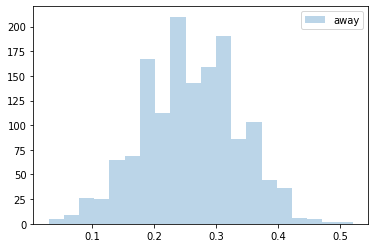

In [112]:
import matplotlib.pyplot as plt
h = rfc.predict_proba(X_test)[:,0]
d = rfc.predict_proba(X_test)[:,1]
a = rfc.predict_proba(X_test)[:,2]
#plt.hist(h, bins = 20, alpha = 0.3, label='home')
#plt.hist(d, bins = 20, alpha = 0.3, label='draw')
plt.hist(a, bins = 20, alpha = 0.3, label='away')
plt.legend()

In [115]:
from sklearn import svm

clf = svm.SVC(kernel='linear', random_state=88)
clf.fit(X_train, y_train)
predssvm = clf.predict(X_test)
print('Accuracy:', round(accuracy_score(y_test, predssvm),4), "|", "Kappa:", round(cohen_kappa_score(y_test, predssvm),4))

Accuracy: 0.5137 | Kappa: 0.0945


In [116]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
predsknn = clf.predict(X_test)
print('Accuracy:', round(accuracy_score(y_test, predsknn),4), "|", "Kappa:", round(cohen_kappa_score(y_test, predsknn),4))

Accuracy: 0.4706 | Kappa: 0.0984


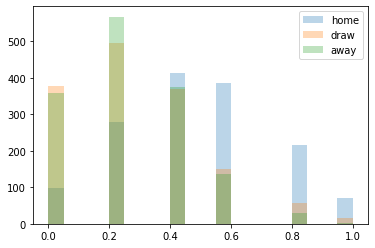

In [117]:
import matplotlib.pyplot as plt
h = clf.predict_proba(X_test)[:,0]
d = clf.predict_proba(X_test)[:,1]
a = clf.predict_proba(X_test)[:,2]
plt.hist(h, bins = 20, alpha = 0.3, label='home')
plt.hist(d, bins = 20, alpha = 0.3, label='draw')
plt.hist(a, bins = 20, alpha = 0.3, label='away')
plt.legend()

In [118]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
predsgbt = clf.predict(X_test)
print('Accuracy:', round(accuracy_score(y_test, predsgbt),4), "|", "Kappa:", round(cohen_kappa_score(y_test, predsgbt),4))

Accuracy: 0.4986 | Kappa: 0.1066


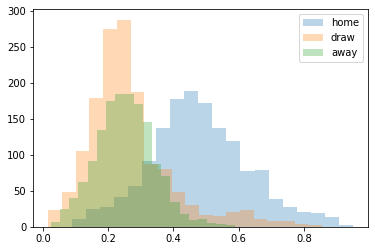

In [119]:
import matplotlib.pyplot as plt
h = clf.predict_proba(X_test)[:,0]
d = clf.predict_proba(X_test)[:,1]
a = clf.predict_proba(X_test)[:,2]
plt.hist(h, bins = 20, alpha = 0.3, label='home')
plt.hist(d, bins = 20, alpha = 0.3, label='draw')
plt.hist(a, bins = 20, alpha = 0.3, label='away')
plt.legend()

In [109]:
pd.Series(clf.feature_importances_, X.columns).sort_values(ascending=False). head()

league_local_local_w        0.085557
last10_awayteam_w           0.076074
league_visitor_visitor_l    0.067825
last10_hometeam_w           0.045865
ref_awayteam_w              0.039331
dtype: float64

### Optimization of GBT model

In [154]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = GradientBoostingClassifier(random_state=88)
acc_scorer = make_scorer(accuracy_score)

for n_est in [50, 100]:
    for l_rate in [0.1]:
        for min_split in[2]:
            for min_leaf in [1]:
                for max_depth in [2,3,4]:
                    parameters = {"loss":["deviance"], "learning_rate": [l_rate], "min_samples_split": [min_split],
                                  "min_samples_leaf": [min_leaf], "max_depth":[max_depth], "subsample":[1.0], 
                                  "n_estimators":[n_est]}
                    grid_obj = GridSearchCV(clf, parameters, cv = 5, verbose = False,scoring=acc_scorer)
                    grid_obj = grid_obj.fit(X_train, y_train)
                    clf = grid_obj.best_estimator_
                    clf.fit(X_train, y_train)
                    predsgbt = clf.predict(X_test)
                    print('Accuracy:', round(accuracy_score(y_test, predsgbt),4), " | ", "Kappa:", 
                          round(cohen_kappa_score(y_test, predsgbt),4), " |  Estimators:",n_est, " |  L-Rate", l_rate, 
                          " |  Min Split:", min_split, " |  Min Leaf:", min_leaf, " |  Max Depth:", max_depth)

Accuracy: 0.4771  |  Kappa: 0.042  |  Estimators: 50  |  L-Rate 0.1  |  Min Split: 2  |  Min Leaf: 1  |  Max Depth: 2
Accuracy: 0.4778  |  Kappa: 0.0501  |  Estimators: 50  |  L-Rate 0.1  |  Min Split: 2  |  Min Leaf: 1  |  Max Depth: 3
Accuracy: 0.4792  |  Kappa: 0.059  |  Estimators: 50  |  L-Rate 0.1  |  Min Split: 2  |  Min Leaf: 1  |  Max Depth: 4
Accuracy: 0.479  |  Kappa: 0.0537  |  Estimators: 100  |  L-Rate 0.1  |  Min Split: 2  |  Min Leaf: 1  |  Max Depth: 2
Accuracy: 0.4792  |  Kappa: 0.0609  |  Estimators: 100  |  L-Rate 0.1  |  Min Split: 2  |  Min Leaf: 1  |  Max Depth: 3
Accuracy: 0.473  |  Kappa: 0.0601  |  Estimators: 100  |  L-Rate 0.1  |  Min Split: 2  |  Min Leaf: 1  |  Max Depth: 4


### Optimization of RF model

In [113]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=88)
acc_scorer = make_scorer(accuracy_score)

for n_est in [250]:
    for max_depth in [12]:
        for min_split in[2]:
            for min_leaf in [1]:
                parameters = {'n_estimators': [n_est], 'max_features': ['log2'], 'criterion': ['entropy'], 
                              'max_depth': [max_depth], 'min_samples_split': [min_split], 
                              'min_samples_leaf': [min_leaf]}
                grid_obj = GridSearchCV(clf, parameters, cv = 5, verbose = False,scoring=acc_scorer)
                grid_obj = grid_obj.fit(X_train, y_train)
                clf = grid_obj.best_estimator_
                clf.fit(X_train, y_train)
                predsrf = clf.predict(X_test)
                print('Accuracy:', round(accuracy_score(y_test, predsrf),4), " | ", "Kappa:", 
                      round(cohen_kappa_score(y_test, predsrf),4), " |  Estimators:",n_est, " |  Max Depth:", max_depth, 
                      " |  Min Split:", min_split, " |  Min Leaf:", min_leaf)                

Accuracy: 0.5178  |  Kappa: 0.1136  |  Estimators: 250  |  Max Depth: 12  |  Min Split: 2  |  Min Leaf: 1


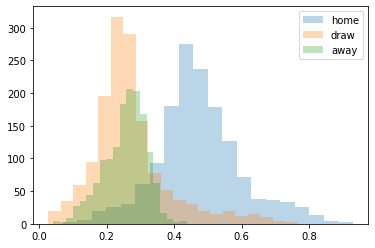

In [114]:
import matplotlib.pyplot as plt
h = clf.predict_proba(X_test)[:,0]
d = clf.predict_proba(X_test)[:,1]
a = clf.predict_proba(X_test)[:,2]
plt.hist(h, bins = 20, alpha = 0.3, label='home')
plt.hist(d, bins = 20, alpha = 0.3, label='draw')
plt.hist(a, bins = 20, alpha = 0.3, label='away')
plt.legend()

In [91]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=12, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=88, verbose=0,
                       warm_start=False)